In [1]:
# Carga de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
# Carga del set de datos
df = pd.read_csv('train.csv')

- `id` - a unique identifier for each tweet
- `text` - the text of the tweet
- `location` - the location the tweet was sent from (may be blank)
- `keyword` - a particular keyword from the tweet (may be blank)
- `target` - in train.csv only, this denotes whether a tweet is about a real disaster (`1`) or not (`0`)

#### Información general del set de datos

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


#### Muestra aleatoria del set de datos

In [4]:
df.sample(5)

,id,keyword,location,text,target
1091,1576,bomb,"Chicago, IL",The MF Life is a vocal and lyrical bomb. Saw h...,0
5559,7934,rainstorm,NaN,@Calum5SOS you look like you got caught in a r...,0
6259,8944,storm,NaN,#gamefeed Warcraft 3-Inspired Mode Likely Hitt...,0
2251,3222,deluged,NaN,Businesses are deluged with invokces. Make you...,0
2239,3199,deluge,Newcastle upon Tyne,Here I'm the UK there isn't a deluge of Canadi...,1


#### Descripción de variables estadísticas del set de datos

In [5]:
df.describe(include=[np.object, np.number]).T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,7613,NaN,NaN,NaN,5441.93,3137.12,1,2734,5408,8146,10873
keyword,7552,221,fatalities,45,NaN,NaN,NaN,NaN,NaN,NaN,NaN
location,5080,3341,USA,104,NaN,NaN,NaN,NaN,NaN,NaN,NaN
text,7613,7503,11-Year-Old Boy Charged With Manslaughter of T...,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
target,7613,NaN,NaN,NaN,0.42966,0.49506,0,0,0,1,1


#### Conversión de tipos de datos

- `id` toma valores del rango `[1, 10873]`, entonces puede usarse el tipo `uint16`.
- `target` puede ser `0` ó `1`.

In [6]:
df['id'] = df['id'].astype(np.uint16)
df['target'] = df['target'].astype(np.uint8)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   uint16
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   uint8 
dtypes: object(3), uint16(1), uint8(1)
memory usage: 200.9+ KB


#### Búsqueda de duplicados

In [7]:
df.duplicated(subset=['id']).sum()

0

Se deduce que todos los tweets son únicos (no hay ducplicados) y que no hay atributos de `text` nulos. Además todas las filas tienen un `target`.

Ahora hay que analizar las palabras.

### Limpieza de datos

Se va a crear un nuevo DataFrame para almacenar los mensajes procesados.

In [8]:
#======= MUESTRA ALEATORIA =======
# Se elige un ancho para la visualización de columnas
pd.set_option('max_colwidth', 150)

display(df.sample(10, random_state=42))

# Se vuelve al valor por default de 'max_colwidth'
pd.reset_option('max_colwidth')

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-imaginable destruction.,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just got soaked in a deluge going for pads and tampons. Thx @mishacollins @/@,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe CoL police can catch a pickpocket in Liverpool Stree... http://t.co/vXIn1gOq4Q,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. I want to thank everyone for making it possible. What a great night.,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts develop a defensive self - one that decreases vulnerability. (3,0
5559,7934,rainstorm,NaN,@Calum5SOS you look like you got caught in a rainstorm this is amazing and disgusting at the same time,0
1765,2538,collision,NaN,my favorite lady came to our volunteer meeting\nhopefully joining her youth collision and i am excite http://t.co/Ij0wQ490cS,1
1817,2611,crashed,NaN,@brianroemmele UX fail of EMV - people want to insert and remove quickly like a gas pump stripe reader. 1 person told me it crashed the POS,1
6810,9756,tragedy,"Los Angeles, CA",Can't find my ariana grande shirt this is a fucking tragedy,0
4398,6254,hijacking,"Athens,Greece",The Murderous Story Of AmericaÛªs First Hijacking http://t.co/EYUGk6byxr,1


In [9]:
import re # Paquete regular expressions.
import string
df_cleaned = df.copy() # Copia del set de datos.

In [10]:
# Función para limpiar el texto de los mensajes.
def clean_text(text):
    # Se convierte el texto a minúsculas.
    text = text.lower()
    # Se quitan los '#'.
    text = re.sub('#', '', text)
    # Se quitan los números.
    text = re.sub('\w*\d\w*', '', text)
    # Se quitan los saltos de línea.
    text = re.sub('\n', ' ', text)
    # Se eliminan las referencias a usuarios '@user'.
    text = re.sub('@\S*', '', text)
    # Se quitan vínculos URL.
    text = re.sub('https{0,1}:\/\/\S*', ' ', text)
    # Se simplifican múltiples espacios a uno solo.
    text = re.sub('(\ ){2,7}', ' ',text)
    # Se quitan los signos de puntuación.
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    return text

df_cleaned['text'] = df_cleaned['text'].apply(lambda x: clean_text(x))

#======= MUESTRA ALEATORIA =======
# Se elige un ancho para la visualización de columnas
pd.set_option('max_colwidth', 150)

display(df_cleaned.sample(10, random_state=42))

# Se vuelve al valor por default de 'max_colwidth'
pd.reset_option('max_colwidth')

,id,keyword,location,text,target
2644,3796,destruction,NaN,so you have a new weapon that can cause unimaginable destruction,1
2227,3185,deluge,NaN,the famp things i do for gishwhes just got soaked in a deluge going for pads and tampons thx,0
5448,7769,police,UK,dt rt ûïthe col police can catch a pickpocket in liverpool stree,1
132,191,aftershock,NaN,aftershock back to school kick off was great i want to thank everyone for making it possible what a great night,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma children of addicts develop a defensive self one that decreases vulnerability,0
5559,7934,rainstorm,NaN,you look like you got caught in a rainstorm this is amazing and disgusting at the same time,0
1765,2538,collision,NaN,my favorite lady came to our volunteer meeting hopefully joining her youth collision and i am excite,1
1817,2611,crashed,NaN,ux fail of emv people want to insert and remove quickly like a gas pump stripe reader person told me it crashed the pos,1
6810,9756,tragedy,"Los Angeles, CA",cant find my ariana grande shirt this is a fucking tragedy,0
4398,6254,hijacking,"Athens,Greece",the murderous story of americaûªs first hijacking,1


#### Generación de una matriz de términos de todos los mensajes.

In [11]:
# Se combinan todos los mensajes.
text_raw = ' '.join(df_cleaned['text'])
# Se simplifican múltiples espacios a uno solo.
text_raw = re.sub('(\ ){2,7}', ' ',text_raw)
text_raw[0:1000]

'our deeds are the reason of this earthquake may allah forgive us all forest fire near la ronge sask canada all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place orders are expected people receive wildfires evacuation orders in california just got sent this photo from ruby alaska as smoke from wildfires pours into a school rockyfire update california hwy closed in both directions due to lake county fire cafire wildfires flood disaster heavy rain causes flash flooding of streets in manitou colorado springs areas im on top of the hill and i can see a fire in the woods theres an emergency evacuation happening now in the building across the street im afraid that the tornado is coming to our area three people died from the heat wave so far haha south tampa is getting flooded hah wait a second i live in south tampa what am i gonna do what am i gonna do fvck flooding raining flooding florida tampabay tampa or days ive lost count flood i

Ahora nos vamos a fijar si las palabras más frecuentes pueden ser consideradas stop words.

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

In [13]:
cv = CountVectorizer(stop_words='english')
# Se usa [text_raw] porque requiere un iterable.
data_cv = cv.fit_transform([text_raw])
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm = data_dtm.T
data_dtm.reset_index(inplace=True)

data_dtm.columns

Index(['index', 0], dtype='object')

In [14]:
# Se renombran las columnas.
data_dtm.rename(columns={'index':'term', 0:'count'}, inplace=True)
# Se toman las primeras 10 palabras con mayor frecuencia.
top_words = data_dtm.sort_values(by='count', ascending=False).head(10)
top_words

,term,count
7214,like,345
6699,just,320
406,amp,303
6106,im,300
8432,new,226
9243,people,195
8444,news,192
3569,dont,191
13458,video,165
3939,emergency,157


Tomamos las primeras 9 palabras más repetidas y la agregamos a la lista de stop words.

In [15]:
# El paquete 'text' contiene las stop words.
from sklearn.feature_extraction import text 

stop_words_to_add = top_words['term'].head(9)
stop_words_to_add

7214       like
6699       just
406         amp
6106         im
8432        new
9243     people
8444       news
3569       dont
13458     video
Name: term, dtype: object

In [16]:
stop_words_new = text.ENGLISH_STOP_WORDS.union(stop_words_to_add)

Ahora se puede limpiar de nuevo el texto de todos los mensajes con las nuevas palabras a ignorar.

In [17]:
cv = CountVectorizer(stop_words=stop_words_new)
# Se usa [text_raw] porque requiere un iterable.
data_cv = cv.fit_transform([text_raw])
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm = data_dtm.T

data_dtm

,0
aa,2
aaaa,1
aaaaaaallll,1
aaaaaand,1
aaarrrgghhh,1
...,...
ûóher,1
ûókody,1
ûónegligence,1
ûótech,1


In [18]:
# Se renombran las columnas.
data_dtm.rename(columns={'index':'term', 0:'count'}, inplace=True)
# Se toman las primeras 10 palabras con mayor frecuencia.
words_freq_des = data_dtm.sort_values(by='count', ascending=False)
words_freq_des.head(10)

,count
emergency,157
disaster,153
police,141
body,125
burning,120
crash,118
storm,117
california,117
suicide,116
got,112


In [19]:
dictionary = words_freq_des['count'].to_dict()

In [20]:
dictionary

{'emergency': 157,
 'disaster': 153,
 'police': 141,
 'body': 125,
 'burning': 120,
 'crash': 118,
 'storm': 117,
 'california': 117,
 'suicide': 116,
 'got': 112,
 'know': 112,
 'day': 112,
 'time': 112,
 'buildings': 111,
 'man': 111,
 'rt': 108,
 'bomb': 104,
 'world': 103,
 'going': 103,
 'nuclear': 102,
 'fires': 100,
 'love': 100,
 'attack': 99,
 'killed': 96,
 'dead': 96,
 'train': 93,
 'war': 91,
 'car': 91,
 'hiroshima': 89,
 'good': 89,
 'today': 89,
 'families': 88,
 'life': 87,
 'accident': 87,
 'think': 86,
 'say': 86,
 'ûªs': 85,
 'watch': 85,
 'want': 80,
 'years': 79,
 'did': 79,
 'way': 78,
 'make': 77,
 'home': 77,
 'collapse': 75,
 'work': 74,
 'look': 73,
 'best': 73,
 'help': 72,
 'need': 72,
 'army': 71,
 'wildfire': 71,
 'really': 71,
 'mass': 71,
 'death': 71,
 'lol': 70,
 'year': 70,
 'let': 69,
 'bombing': 68,
 'pm': 68,
 'right': 68,
 'youre': 67,
 'hot': 66,
 'black': 66,
 'school': 66,
 'forest': 65,
 'fatal': 65,
 'northern': 64,
 'read': 64,
 'water': 63,

Ahora se pueden usar todas las stop words para generar la nube de palabras.

In [21]:
from wordcloud import WordCloud
# stopwords=stop_words_new
wc = WordCloud(stopwords=stop_words_new, background_color="white", colormap="Dark2", \
               max_font_size=150, max_words=100, scale=5, random_state=42) #scale > 1 mejora la resolución del plot.

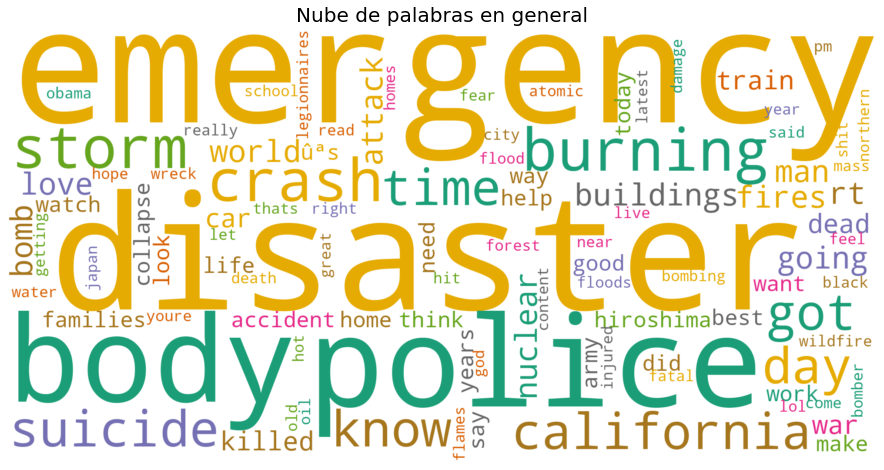

In [22]:
plt.figure(figsize = (16,8))

'''La instancia wc de WordCloud puede generar la nube a partir de la frecuencia
de las palabras. Pero para eso necesita un dictionario con las frecuencias.'''

wc.generate_from_frequencies(dictionary)

plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title('Nube de palabras en general', fontsize=20)

plt.show()

---
---
## Análisis de veracidad del mensaje según su longitud

In [23]:
# Se agrega un columna para la longitud del mensaje.
df['length'] = df['text'].str.len()
# Se informan las mediciones pedidas.
print('Características de longitud del texto del mensaje')
print('Máxima:', df['length'].max(), \
'\tMínina:', df['length'].min(), \
'\tMedia:', np.round(df['length'].mean(), decimals = 0))

Características de longitud del texto del mensaje
Máxima: 157 	Mínina: 7 	Media: 101.0


In [24]:
# Se arma nuevo DataFrame agrupando por longitud de mensaje
join = pd.DataFrame()
join['is_true'] = df.groupby('length')['target'].agg('sum')
join['total'] = df.groupby('length')['target'].agg('count')
join['portion_is_true'] = round(join['is_true'] / join['total'], 3)
# Se quitan los casos extremos.
clean = join.loc[join['portion_is_true'] < 1]
display(clean.nlargest(5, 'portion_is_true'))
print('Promedio de las cinco longitudes con mejor índice de veracidad:', \
clean.nlargest(5, 'portion_is_true').index.values.mean())
print('Mediana de las cinco longitudes con mejor índice de veracidad:', \
np.median(clean.nlargest(5, 'portion_is_true').index.values))

,is_true,total,portion_is_true
length,,,
136,277.0,401,0.691
91,60.0,88,0.682
135,119.0,191,0.623
116,40.0,67,0.597
137,125.0,210,0.595


Promedio de las cinco longitudes con mejor índice de veracidad: 123.0
Mediana de las cinco longitudes con mejor índice de veracidad: 135.0


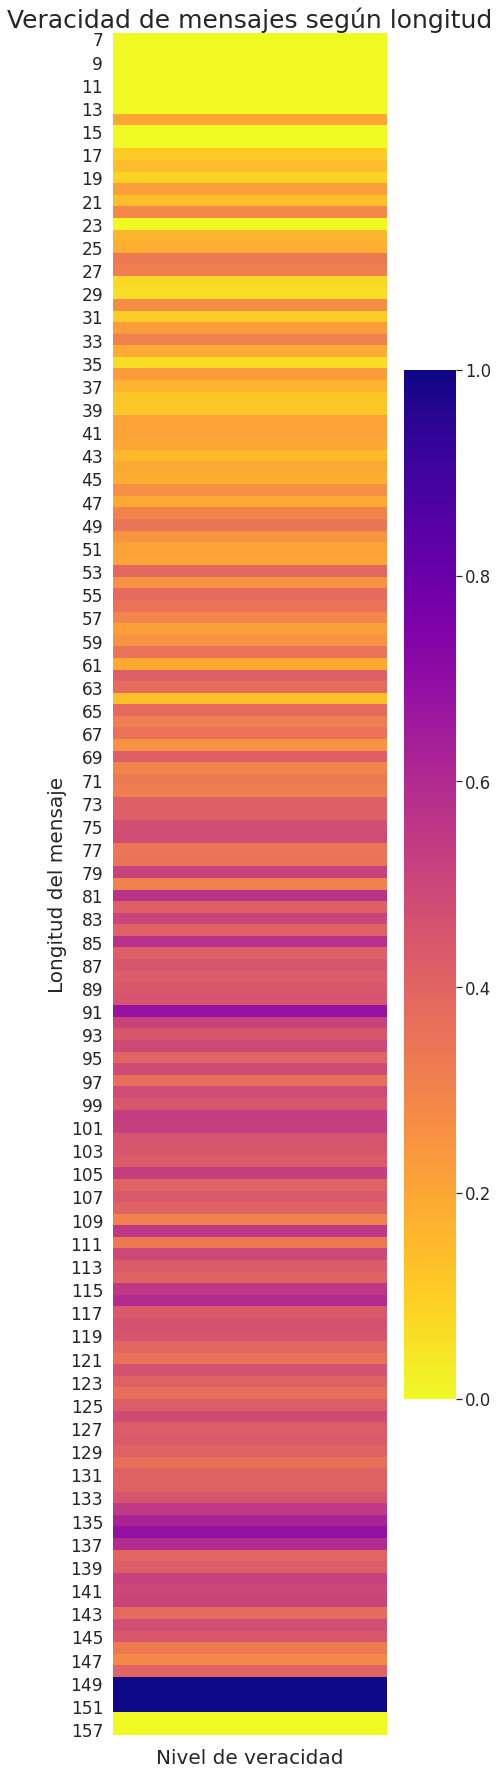

In [25]:
# Plot
plt.figure(figsize = (7,25))
sb.set(font_scale = 1.5)
plot = sb.heatmap(join[['portion_is_true']], cmap = 'plasma_r', \
cbar = True, xticklabels = [''])
plt.title('Veracidad de mensajes según longitud',fontsize = 25)
plot.set_xlabel('Nivel de veracidad', fontsize = 20)
plot.set_ylabel('Longitud del mensaje', fontsize = 20)
plt.xticks(fontsize = 17, rotation = 0, ha = 'center', va = 'top')
plt.yticks(fontsize = 17, rotation = 0)
plt.tight_layout() # Para que no recorte los títulos.
plt.show()